In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report


from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


# supress some warnings that mess up my slides
import warnings; warnings.simplefilter('ignore')

## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [2]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [3]:
print(books.shape)

(16559, 7)


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [4]:
target_genres = ["Children's literature",
                 "Science Fiction",
                 "Novel",
                 "Fantasy",
                 "Mystery"]

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

print(genre_books.shape)
print(genre_books.head(10))

(8954, 5)
                                title             author        date  \
0                         Animal Farm      George Orwell  1945-08-17   
1                  A Clockwork Orange    Anthony Burgess        1962   
2                          The Plague       Albert Camus        1947   
4                A Fire Upon the Deep       Vernor Vinge               
6                A Wizard of Earthsea  Ursula K. Le Guin        1968   
8     Blade Runner 3: Replicant Night        K. W. Jeter  1996-10-01   
9   Blade Runner 2: The Edge of Human        K. W. Jeter  1995-10-01   
20                              Crash      J. G. Ballard        1973   
21                   Children of Dune      Frank Herbert        1976   
23                  Chapterhouse Dune      Frank Herbert     1985-04   

                                              summary                  genre  
0    Old Major, the old boar on the Manor Farm, ca...  Children's literature  
1    Alex, a teenager living in near-fu

In [5]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Feature Exaction

Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

In [6]:
genre_books

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy
...,...,...,...,...,...
16525,Beautiful Creatures,Margaret Stohl,2009-12-01,Beautiful Creatures is set in fictional Gatli...,Fantasy
16526,Beautiful Chaos,Gary Russell,,"After returning home, more strange things are...",Fantasy
16531,Guardians of Ga'Hoole Book 4: The Siege,Helen Dunmore,2004-05-01,==Receptio,Fantasy
16532,The Casual Vacancy,J. K. Rowling,2012-09-27,"The novel is split into seven parts, the firs...",Fantasy


In [7]:
genre_books.summary.head()

0     Old Major, the old boar on the Manor Farm, ca...
1     Alex, a teenager living in near-future Englan...
2     The text of The Plague is divided into five p...
4     The novel posits that space around the Milky ...
6     Ged is a young boy on Gont, one of the larger...
Name: summary, dtype: object

In [8]:
print(genre_books.isnull().sum())

title      0
author     0
date       0
summary    0
genre      0
dtype: int64


In [9]:
len(genre_books.summary) #8954
len(genre_books.genre) #8954

8954

In [10]:
X = genre_books['summary']
y = genre_books['genre']

In [11]:
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(X)
vectorizer_msg = vectorizer.transform(X)

#create df to contain words
word_matrix = vectorizer_msg.toarray() 
df = pd.DataFrame(word_matrix, columns = vectorizer.get_feature_names()) #create df from matrix
#df.shape

#bag-of-words
dfsum = df.sum(axis=0, skipna=True)
bow = dfsum.sort_values(ascending=False)[:30]
#bow

In [12]:
vectorizer2 = CountVectorizer(stop_words='english')
vectorizer2 = vectorizer2.fit(X)
vectorizer_msg2 = vectorizer2.transform(X)

#create df to contain words
word_matrix2 = vectorizer_msg2.toarray()
df = pd.DataFrame(word_matrix2, columns = vectorizer2.get_feature_names())
#df.shape

#bag-of-words
dfsum2 = df.sum(axis=0, skipna=True)
bow2 = dfsum2.sort_values(ascending=False)[:30]
#bow2

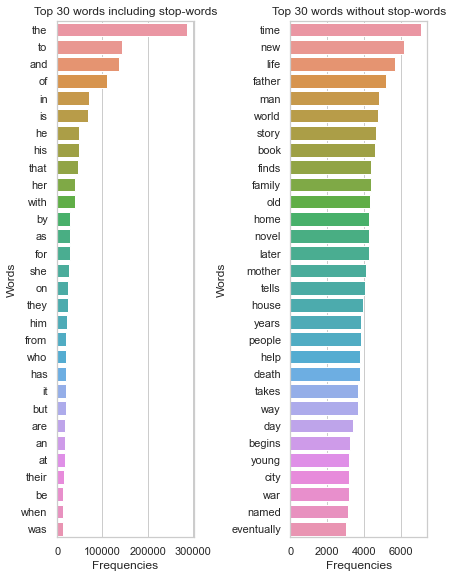

In [13]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize = (6, 8))
g1 = sns.barplot(bow.values, bow.index, ax=ax[0]).set(xlabel='Frequencies', ylabel='Words', title = 'Top 30 words including stop-words')
g2 = sns.barplot(bow2.values, bow2.index, ax=ax[1]).set(xlabel='Frequencies', ylabel='Words', title = 'Top 30 words without stop-words')
fig.tight_layout(pad=0.5) #adjust padding between subplots
plt.show()

In [14]:
#Encoding categorical Values
labes = {"Children's literature":"0", "Science Fiction":"1", "Novel":"2", "Fantasy":"3", "Mystery":"4"}
genre_books['genre_'] = genre_books['genre'].apply(lambda x: labes[x])
genre_books["genre_"] = genre_books["genre_"].astype('category')
genre_books["genre_"] = genre_books["genre_"].cat.codes

In [15]:
genre_books.dtypes
genre_books

,title,author,date,summary,genre,genre_
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,0
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,2
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,2
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,3
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,3
...,...,...,...,...,...,...
16525,Beautiful Creatures,Margaret Stohl,2009-12-01,Beautiful Creatures is set in fictional Gatli...,Fantasy,3
16526,Beautiful Chaos,Gary Russell,,"After returning home, more strange things are...",Fantasy,3
16531,Guardians of Ga'Hoole Book 4: The Siege,Helen Dunmore,2004-05-01,==Receptio,Fantasy,3
16532,The Casual Vacancy,J. K. Rowling,2012-09-27,"The novel is split into seven parts, the firs...",Fantasy,3


In [16]:
X = genre_books['summary']
y = genre_books['genre_']

In [17]:
start = time.time()
tvec = TfidfVectorizer(max_features=20000, stop_words='english')
X_tfidf = tvec.fit_transform(X)
end = time.time()
Time = end - start
print('Time: ', Time)

Time:  4.5446248054504395


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=142)

In [19]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (7163, 20000)
y_train shape:  (7163,)
X_test shape:  (1791, 20000)
y_test shape:  (1791,)


## Multinomial Naive Bayes

### Model Training

Then, train two predictive models from the given data set.

In [20]:
start = time.time()
modelNB = MultinomialNB(alpha=0.005)
modelNB.fit(X_train, y_train)
end = time.time()
Time = end - start
print('Time: ', Time)

Time:  0.016955137252807617


### Model Evaluation

Finally, evaluate and compare the learned predictive models.

In [21]:
#Evaluating model on test set
y_pred = modelNB.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_test, y_pred, target_names = target_genres))

Accuracy scores: 0.6795086543830262
                       precision    recall  f1-score   support

Children's literature       0.69      0.41      0.51       237
      Science Fiction       0.74      0.72      0.73       400
                Novel       0.56      0.75      0.64       430
              Fantasy       0.74      0.75      0.75       453
              Mystery       0.73      0.63      0.68       271

             accuracy                           0.68      1791
            macro avg       0.69      0.65      0.66      1791
         weighted avg       0.69      0.68      0.68      1791



In [22]:
#Evaluating model on train set
y_pred = modelNB.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_train, y_pred, target_names = target_genres))

Accuracy scores: 0.9382940108892922
                       precision    recall  f1-score   support

Children's literature       0.96      0.93      0.94       855
      Science Fiction       0.89      0.96      0.92      1497
                Novel       0.93      0.94      0.93      1828
              Fantasy       0.96      0.91      0.94      1858
              Mystery       0.97      0.96      0.96      1125

             accuracy                           0.94      7163
            macro avg       0.94      0.94      0.94      7163
         weighted avg       0.94      0.94      0.94      7163



In [23]:
#test_text = ["Nine years after Emperor Paul Muad'dib walked", 'The novel posits that space around the Milky']
#test_text_vec = tvec.transform(test_text)
#y_pred = modelNB.predict(test_text_vec)
#y_pred

## Gaussian Naive Bayes

### Model Training

In [24]:
start = time.time()
modelGNB = GaussianNB()
modelGNB.fit(X_train.toarray(), y_train)
end = time.time()
Time = end - start
print('Time: ', Time)

Time:  5.943720817565918


In [25]:
#test_text = ["Nine years after Emperor Paul Muad'dib walked", 'The novel posits that space around the Milky']
#test_text_vec = tvec.transform(test_text)
#y_pred = modelGNB.predict(test_text_vec.toarray())
#y_pred

### Model Evaluation

In [26]:
#Evaluating model on test set
y_pred = modelGNB.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_test, y_pred, target_names = target_genres))

Accuracy scores: 0.5097710776102736
                       precision    recall  f1-score   support

Children's literature       0.45      0.22      0.30       237
      Science Fiction       0.55      0.53      0.54       400
                Novel       0.41      0.54      0.47       430
              Fantasy       0.59      0.67      0.63       453
              Mystery       0.53      0.41      0.46       271

             accuracy                           0.51      1791
            macro avg       0.51      0.48      0.48      1791
         weighted avg       0.51      0.51      0.50      1791



In [27]:
#Evaluating model on train set
y_pred = modelGNB.predict(X_train.toarray())
accuracy = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_train, y_pred, target_names = target_genres))

Accuracy scores: 0.9550467681139188
                       precision    recall  f1-score   support

Children's literature       0.86      1.00      0.93       855
      Science Fiction       0.94      0.97      0.96      1497
                Novel       0.99      0.94      0.96      1828
              Fantasy       1.00      0.92      0.96      1858
              Mystery       0.92      0.98      0.95      1125

             accuracy                           0.96      7163
            macro avg       0.95      0.96      0.95      7163
         weighted avg       0.96      0.96      0.96      7163



## Logistic Regression

### Model Training

In [28]:
start = time.time()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
end = time.time()
Time = end - start
print('Time: ', Time)

Time:  3.704817533493042


### Model Evaluation

In [29]:
#Evaluating model on test set
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']
print('Accuracy scores:', accuracy)
print(classification_report(y_test, y_pred, target_names = target_genres))

Accuracy scores: 0.6934673366834171
                       precision    recall  f1-score   support

Children's literature       0.76      0.41      0.53       237
      Science Fiction       0.76      0.69      0.73       400
                Novel       0.59      0.79      0.68       430
              Fantasy       0.70      0.79      0.74       453
              Mystery       0.79      0.62      0.69       271

             accuracy                           0.69      1791
            macro avg       0.72      0.66      0.67      1791
         weighted avg       0.71      0.69      0.69      1791



In [30]:
#Evaluating model on train set
y_pred = logreg.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_train, y_pred, target_names = target_genres))

Accuracy scores: 0.8954348736562893
                       precision    recall  f1-score   support

Children's literature       0.93      0.79      0.85       855
      Science Fiction       0.89      0.92      0.90      1497
                Novel       0.85      0.93      0.89      1828
              Fantasy       0.91      0.92      0.91      1858
              Mystery       0.95      0.86      0.90      1125

             accuracy                           0.90      7163
            macro avg       0.91      0.88      0.89      7163
         weighted avg       0.90      0.90      0.90      7163



## Decision Tree

### Model Training

In [31]:
start = time.time()
decisionTree = tree.DecisionTreeClassifier()
decisionTree.fit(X_train, y_train)
end = time.time()
Time = end - start
print('Time: ', Time)

Time:  9.144002199172974


### Model Evaluation

In [32]:
#Evaluating model on test set
y_pred = decisionTree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_test, y_pred, target_names = target_genres))

Accuracy scores: 0.4785036292573981
                       precision    recall  f1-score   support

Children's literature       0.32      0.26      0.29       237
      Science Fiction       0.58      0.52      0.55       400
                Novel       0.43      0.48      0.45       430
              Fantasy       0.52      0.57      0.54       453
              Mystery       0.47      0.46      0.46       271

             accuracy                           0.48      1791
            macro avg       0.46      0.46      0.46      1791
         weighted avg       0.48      0.48      0.48      1791



In [33]:
#Evaluating model on train set
y_pred = decisionTree.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_train, y_pred, target_names = target_genres))

Accuracy scores: 0.9994415747591792
                       precision    recall  f1-score   support

Children's literature       1.00      1.00      1.00       855
      Science Fiction       1.00      1.00      1.00      1497
                Novel       1.00      1.00      1.00      1828
              Fantasy       1.00      1.00      1.00      1858
              Mystery       1.00      1.00      1.00      1125

             accuracy                           1.00      7163
            macro avg       1.00      1.00      1.00      7163
         weighted avg       1.00      1.00      1.00      7163



## Random Forest

### Model Training

In [34]:
start = time.time()
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
end = time.time()
Time = end - start
print('Time: ', Time)

Time:  16.423592805862427


### Model Evaluation

In [35]:
#Evaluating model on test set
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_test, y_pred, target_names = target_genres))

Accuracy scores: 0.6471245114461195
                       precision    recall  f1-score   support

Children's literature       0.65      0.27      0.38       237
      Science Fiction       0.73      0.69      0.71       400
                Novel       0.56      0.75      0.64       430
              Fantasy       0.65      0.77      0.71       453
              Mystery       0.73      0.55      0.62       271

             accuracy                           0.65      1791
            macro avg       0.66      0.60      0.61      1791
         weighted avg       0.66      0.65      0.64      1791



In [36]:
#Evaluating model on train set
y_pred = rfc.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracy)
print(classification_report(y_train, y_pred, target_names = target_genres))

Accuracy scores: 0.9994415747591792
                       precision    recall  f1-score   support

Children's literature       1.00      1.00      1.00       855
      Science Fiction       1.00      1.00      1.00      1497
                Novel       1.00      1.00      1.00      1828
              Fantasy       1.00      1.00      1.00      1858
              Mystery       1.00      1.00      1.00      1125

             accuracy                           1.00      7163
            macro avg       1.00      1.00      1.00      7163
         weighted avg       1.00      1.00      1.00      7163



__Deep Learning__

## Summary
### Best Model Selection
| Model  | Test Set Accuracy | Train Set Accuracy | Time |
| --- | --- | --- | --- |
| Multinomial Naive Bayes | 68% | 94% | 0.03 s |
| Gaussian Naive Bayes | 51% | 96% | 4.14 s |
| Logistic Regression | 69% | 90% | 4.19 s |
| Decision Tree | 48% | 100% | 8.55 s |
| Random Forest | 64% | 100% | 18.41 s |

Overall, most of the models have quite good accuracy. 
It can be observed that Gaussian Naive Bayes, Decision Tree and Random Forest model seem to be overfit since they have an extremely high train set accuracy but a very lower test set accuracy. Morever,...

__Pipeline__

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn that behaves like a compound classifier.

https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

### Model inference

In [37]:
test_text = ["Nine years after Emperor Paul Muad'dib walked", 'The novel posits that space around the Milky']
test_text_vec = tvec.transform(test_text)
#The ctaul genres(y) are Fantasy, Science Fiction

In [38]:
y_pred = modelNB.predict(test_text_vec)
y_pred
print(y_pred)
for i in y_pred:
    print('Genre: ', format(target_genres[i]))


[2 1]
Genre:  Novel
Genre:  Science Fiction


In [39]:
y_pred = modelNB.predict(test_text_vec.toarray())
y_pred
print(y_pred)
for i in y_pred:
    print('Genre: ', format(target_genres[i]))

[2 1]
Genre:  Novel
Genre:  Science Fiction


In [40]:
y_pred = logreg.predict(test_text_vec)
y_pred
print(y_pred)
for i in y_pred:
    print('Genre: ', format(target_genres[i]))

[3 1]
Genre:  Fantasy
Genre:  Science Fiction


In [41]:
y_pred = decisionTree.predict(test_text_vec)
y_pred
print(y_pred)
for i in y_pred:
    print('Genre: ', format(target_genres[i]))

[3 2]
Genre:  Fantasy
Genre:  Novel


In [42]:
y_pred = rfc.predict(test_text_vec)
y_pred
print(y_pred)
for i in y_pred:
    print('Genre: ', format(target_genres[i]))

[3 1]
Genre:  Fantasy
Genre:  Science Fiction
